## Using RNNs to add two binary strings ##

In this first lab, to get familiar with RNNs, we will explore the simple problem of teaching an RNN to add binary strings. Recall, like grade-school addition, binary addition moves from the right-most bit (least-significant bit or LSB) towards the left-most bit (most-significant) bit, with a carry bit passed from the previous addition.

Following is the "truth table" for a "full-adder" (i.e., carry-in, carry-out):

     i1   i2   carry-in  |  sum  carry-out
     --------------------+----------------
     0    0       0      |   0      0
     0    0       1      |   1      0
     0    1       0      |   1      0
     0    1       1      |   0      1
     1    0       0      |   1      0
     1    0       1      |   0      1
     1    1       0      |   0      1
     1    1       1      |   1      1

where, `i1` and `i2` are the input bits

The RNN is fed two bit-sequences and the target "sum" sequence.
The sequence is ordered from LSB to MSB, i.e., time-step 1 (t=1) corresponds to LSB, and the last time-step is the MSB.

For example:
If the bit strings 010 (integer value = 2) and 011 (integer value = 3) are to be added to produce the sum 101 (integer value 5), the following is the sequence of inputs and targets to the RNN when training:

    time | i1  i2 | output
    -----+--------+--------
     1   | 0    1 |   1
     2   | 1    1 |   0
     3   | 0    0 |   1

Note, in the example above, the "carry" bit is not explicitly provided as the input, and the RNN has to *learn* the concept of a carry-bit


### Overview ###
We will be using [PyTorch](http://pytorch.org) for implementation.

This question is planned as below:

    1. First we discuss how the training samples are generated
    2. Next, the we discuss the input and output format used for the RNN
    3. We set up the RNN network 
    4. We explore the effects of various parameters.

In [1]:
# coding: utf-8
# =============================================================================
# Make a simple RNN learn binray addition 
# Binary string pairs and the sum is generated for a given #numBits
# ============================================================================
# for ML Summer School 2017 at IIIT - HYD
# Author- Minesh Mathew
# ==============================================================================
# import various modules
from __future__ import print_function

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
import random
import sys
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
random.seed( 10 ) # set the random seed (for reproducibility)

## Preparing the Training Data ##

###   Radom binary strings of required length as training data ###
The function `getSample` below takes a string-length `L` as input and returns a training sample to be fed to the RNN.


For a given length `L`, a training sample is a 2-tuple of (`input`, `output`), where

* `input` is a tensor of size [`L+1x2`]:<br>
	* The second dimension of 2, corresponds to 2 inputs which are
		to be summed together.
	* The first row is for LSBs, and the last row correspond to MSBs.
	* The bit-strings are `L+1` due to a possible carry when adding two `L`-length bit strings.

* `output` is a tensor of size `L+1`, which is the sum of the inputs


In [2]:
def getSample(stringLength, testFlag=False):
    """
    Returns a random sample for bit-string addition.
    STRINGLENGTH: (int scalar) (one less than) length of the bit-string to return.
    TESTFLAG: (boolean) if True, the returned sample is printed.
    
    Returns:
        a 2-tuple of (Input,Output), where:
        INPUT: (L+1 x 2) dimensional tensor of the inputs, where L==STRINGLENGTH
        OUTPUT: (L+1) dimensional "target" vector, which is the binary sum of inputs.
    """
    lowerBound=pow(2,stringLength-1)+1
    upperBound=pow(2,stringLength)
    
    num1=random.randint(lowerBound,upperBound)
    num2=random.randint(lowerBound,upperBound)

    num3=num1+num2
    num3Binary=(bin(num3)[2:])

    num1Binary=(bin(num1)[2:])
    num2Binary=(bin(num2)[2:])

    if testFlag==1:
        print('input numbers and their sum  are', num1, ' ', num2, ' ', num3)
        print ('binary strings are', num1Binary, ' ' , num2Binary, ' ' , num3Binary)
    len_num1= (len(num1Binary))

    len_num2= (len(num2Binary))
    len_num3= (len(num3Binary))

    # since num3 will be the largest, we pad  other numbers with zeros to that num3_len
    num1Binary= ('0'*(len(num3Binary)-len(num1Binary))+num1Binary)
    num2Binary= ('0'*(len(num3Binary)-len(num2Binary))+num2Binary)

    # forming the input sequence
    # the input at first timestep is the least significant bits of the two input binary strings
    # x will be then a len_num3 ( or T ) * 2 array
    x=np.zeros((len_num3,2),dtype=np.float32)
    for i in range(0, len_num3):
        x[i,0]=num1Binary[len_num3-1-i] # note that MSB of the binray string should be the last input along the time axis
        x[i,1]=num2Binary[len_num3-1-i]
    # target vector is the sum in binary
    # convert binary string in <string> to a numpy 1D array
    #https://stackoverflow.com/questions/29091869/convert-bitstring-string-of-1-and-0s-to-numpy-array
    y=np.array(map(int, num3Binary[::-1]))
    return x,y 



### Model Input ###
As noted above, the inputs are `L+1x2` dimensional tensors, with the first row corresponding to LSB and the last to MSB. As addition proceeds from LSB to MSB, the `input` rows are fed  one-by-one, starting from the top, proceeding all the way to the last row.<br>
__Note__: This is not shown explicitly in the provided code, but is done internally.


### Model Output  ###
At each time-step the model needs to predict the target "sum".
We do an affine projection (linear + bias) of the RNN hidden state at each time step to a single value $s_t$:

$$s_t = W_{hy}h_t + b_{hy}$$

Since, this output value $s_t$ is unconstrained, and we need a value in the set $\{0,1\}$, we use the `sigmoid` function to squash $s_t$ to the $[0,1]$ range:

$$y_t = \operatorname{sigmoid}(s_t) = \frac{1}{1+e^{-s_t}}$$

## Training Loss ##
We use the `Mean-Squared-Error` loss function to compare the predicted value $y_t$, and the target $\tilde{y_t}$:

$$\mathcal{L}_t(y_t,\tilde{y_t}) = \left(y_t - \tilde{y_t}\right)^2$$

__Note__: The total loss for a given sequence is the sum of all the losses from each time-step.


The image below shows a schematic of the "unrolled" RNN for binary-addition:


![network architecture](binAdd.png)


## Model Implementation ##
The following class `Adder` implements the above RNN. We only give the forward-pass implementation.
The backward pass is calcuated automatically by PyTorch's auto-grad.

The only parameters passed to the model is the size (dimensionality) of the hidden state.
Bigger state, means higher capacity.


In [3]:
class Adder (nn.Module):
    def __init__(self,stateDim):
        super(Adder, self).__init__()
        self.stateDim = stateDim
        self.inputDim = 2  # two for the two inputs
        self.outputDim = 1  # one for the "score"
        # currently the model uses the 'LSTM' cell. You could try
        # others like: tanh, GRU. See: https://github.com/pytorch/examples/blob/master/word_language_model/model.py#L11
        self.lstm = nn.LSTM(self.inputDim, self.stateDim )
        self.outputLayer = nn.Linear(self.stateDim, self.outputDim)

    def forward(self, x):
        """
        X: [L,B,inputDim(=2)] dimensional input tensor
            L: Sequence length
            B: is the "batch" dimension. As we are training on 
               single examples, B = 1 for us.
        """
        lstmOut,_ = self.lstm(x)
        L,B,D  = lstmOut.size(0),lstmOut.size(1),lstmOut.size(2)
        lstmOut = lstmOut.contiguous() 
        # before  feeding to linear layer we squash one dimension
        lstmOut = lstmOut.view(L*B,D)
        pred = self.outputLayer(lstmOut) # project lstm states to "output"
        # reshape actiavtions to T*B*outputDim
        pred = pred.view(L,B,-1).squeeze(1)
        return pred

### Training the Network ###

The model is trained on bit-strings of length `stringLen` sampled randomly.

For simplicity, training code runs for a fixed number of epochs (or iterations). In practice, the training should be monitored with performance on a held-out or validation set, in order to avoid over-fitting.

We use the [`Adam` optimizer](https://arxiv.org/abs/1412.6980).

The model runs fast enough to train on the CPU itself (GPUs are not used).

Lets train our first RNN model!

In [4]:
# set here the size of the RNN state:
stateSize = 10
# set here the size of the binary strings to be used for training:
stringLen = 3

# create the model:
model = Adder(stateSize)
print ('Model initialized')

# create the loss-function:
lossFunction = nn.MSELoss() # or nn.CrossEntropyLoss() -- see question #2 below

# uncomment below to change the optimizers:
#optimizer = optim.SGD(model.parameters(), lr=3e-2, momentum=0.8)
optimizer = optim.Adam(model.parameters(),lr=0.01)
iterations = 500
min_epochs = 20
num_epochs,totalLoss = 0,float("inf")
while num_epochs < min_epochs:
    print("[epoch %d/%d] Avg. Loss for last 500 samples = %lf"%(num_epochs+1,min_epochs,totalLoss))
    num_epochs += 1
    totalLoss = 0
    for i in range(0,iterations):
        # get a new random training sample:
        x,y = getSample(stringLen)
        # zero the gradients from the previous time-step:
        model.zero_grad()
        #convert to torch tensor and variable:
        ## unsqueeze() is used to add the extra BATCH dimension:
        x_var = autograd.Variable(torch.from_numpy(x).unsqueeze(1).float()) 
        seqLen = x_var.size(0)
        x_var = x_var.contiguous()
        y_var = autograd.Variable(torch.from_numpy(y).float())
        # push the inputs through the RNN (this is the forward pass):
        pred = model(x_var)
        # compute the loss:
        loss = lossFunction(pred,y_var)
        totalLoss += loss.data[0]
        optimizer.zero_grad()
        # perform the backward pass:
        loss.backward()
        # update the weights:
        optimizer.step()
    totalLoss=totalLoss/iterations
print('Training finished!')

Model initialized
[epoch 1/20] Avg. Loss for last 500 samples = inf
[epoch 2/20] Avg. Loss for last 500 samples = 0.135644
[epoch 3/20] Avg. Loss for last 500 samples = 0.016145
[epoch 4/20] Avg. Loss for last 500 samples = 0.003927
[epoch 5/20] Avg. Loss for last 500 samples = 0.000997
[epoch 6/20] Avg. Loss for last 500 samples = 0.000200
[epoch 7/20] Avg. Loss for last 500 samples = 0.001143
[epoch 8/20] Avg. Loss for last 500 samples = 0.000666
[epoch 9/20] Avg. Loss for last 500 samples = 0.000082
[epoch 10/20] Avg. Loss for last 500 samples = 0.000471
[epoch 11/20] Avg. Loss for last 500 samples = 0.000306
[epoch 12/20] Avg. Loss for last 500 samples = 0.000572
[epoch 13/20] Avg. Loss for last 500 samples = 0.000159
[epoch 14/20] Avg. Loss for last 500 samples = 0.000964
[epoch 15/20] Avg. Loss for last 500 samples = 0.000161
[epoch 16/20] Avg. Loss for last 500 samples = 0.000315
[epoch 17/20] Avg. Loss for last 500 samples = 0.000237
[epoch 18/20] Avg. Loss for last 500 samples

### Testing the model ###
We now test the trained model. We get random inputs again (as before),
push them through the RNN, getting a prediction (in the [0,1] range due to the sigmoid) at every time step.
We discretize the output to 0 or 1, by thresholding at 0.5.

In [5]:
def test_by_length(stringLen,n_samples=100,verbose=True):
    n_samples = min(n_samples,2**stringLen)
    total_correct, num_bits = 0,0
    for i in range(n_samples):
        x,y = getSample(stringLen,testFlag=verbose)
        x_var = autograd.Variable(torch.from_numpy(x).unsqueeze(1).float())
        y_var = autograd.Variable(torch.from_numpy(y).float())
        seqLen = x_var.size(0)
        x_var = x_var.contiguous()
        finalScores = model(x_var).data.t().numpy()
        # to get the final predictions, threshold the output of RNN at 0.5:
        ## this needs to be changed when you switch to cross-entropy loss (see question #2).
        bits = (finalScores > 0.5).astype(np.int32)
        # calculate the accuracy: 
        y_pred = bits
        corr = y_pred==y; total_correct += np.sum(corr); num_bits += len(y)
        if verbose:
            print('sum predicted by RNN is ',y_pred)
            print('bit-accuracy : %s'%(np.sum(corr)/(len(y)+0.0)))
            print(40*'*')
    accuracy = total_correct / (num_bits + 0.0)
    if verbose:
        print(40*'*')
        print('Final bit-accuracy for strings of length %d = %.3f'%(stringLen,accuracy))
        print(40*'*')
    return accuracy


## Testing Model Generalization Ability##
Recall that the model was trained on bit-strings of length 3.
We will now test the trained model on bit-strings of different lengths (other than 3):<br>
We will sweep the length-range from 2 to 20, and plot the bit-accuracy.


<IPython.core.display.Javascript object>


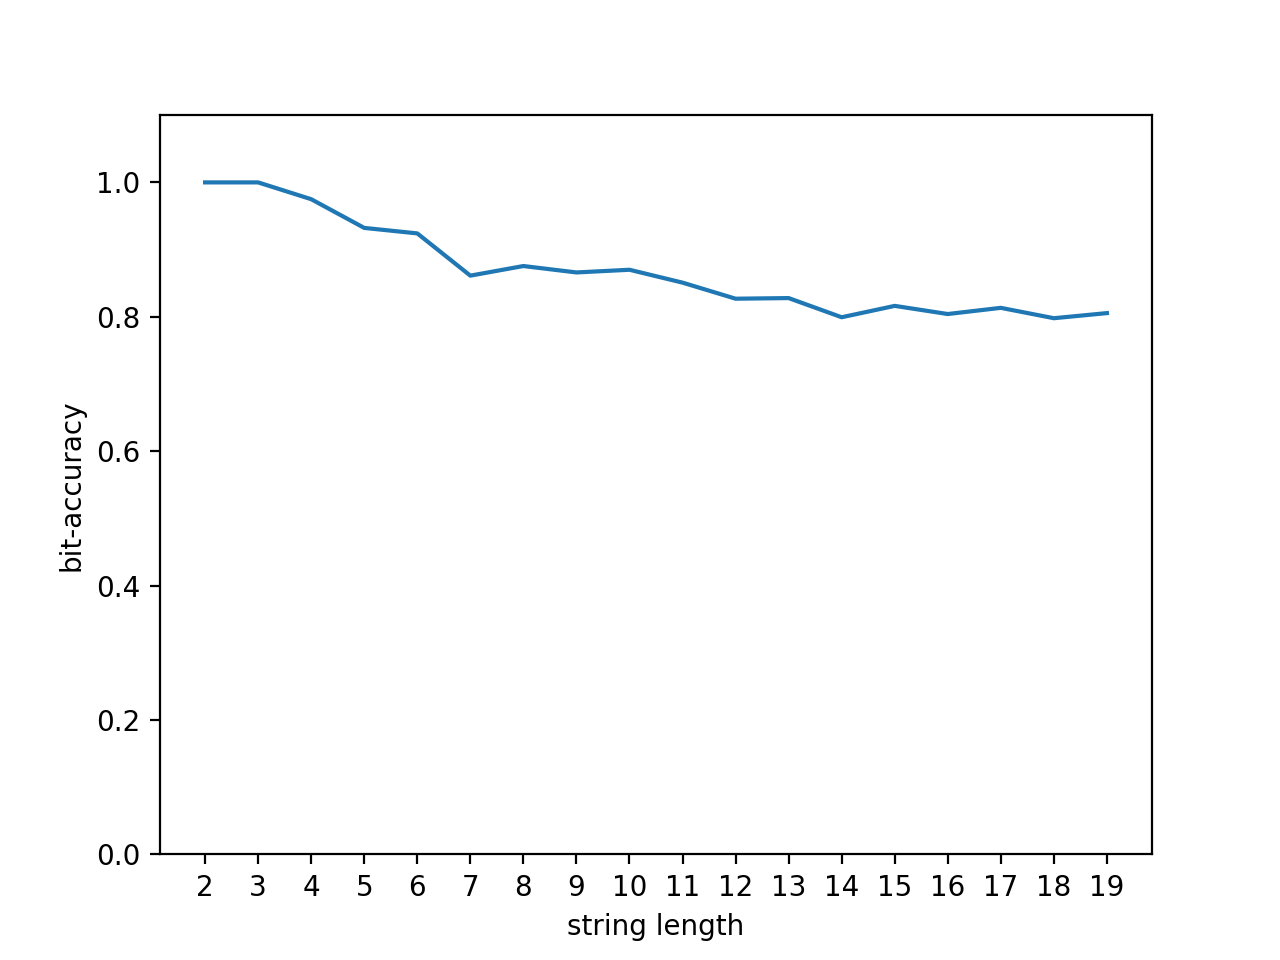

In [8]:
string_len = np.arange(2,20)
# set "verbose" to true to print out detailed information:
bit_accuracy = [test_by_length(l,verbose=False,n_samples=100) for l in string_len]
# plot the accuracy:
plt.plot(string_len,bit_accuracy)
plt.xlabel('string length'); plt.ylabel('bit-accuracy'); plt.xticks(string_len,string_len)
plt.ylim([0,1.1]); 


__Question 1:__ Recall that the model was trained on bit-strings of length 3. When tested on longer distances, the accuracy drops (check the plot above).

1. How does the state-size affect the accuracy for longer strings? Retrain the model with different state-sizes, specifically 50 and 100, and check how the accuracy for the longer strings is affected. Can you explain this trend?<br><br>

2. How does training on longer bit-sequences affect the generalization ability:
    * Train on 5 and 10 bit-strings, while keeping the state-size at 10. What do you observe?
    * Now, again train on bit-strings of length 5, but increase the state size to 100. What trend do you observe?
   

__Question 2:__ [Challenge question] In the current setup, the model predicts a single `score`, and uses the squared-loss. In the lectures we saw using training RNNs to predict output probabilities for each category (=2 in our case, one for 0, and one for 1), and using softmax followed by cross-entropy as the loss function:

Still, use affine (or linear) projection from hidden-state to output, but now regress to two "scores" (what should be dimensionality of `W_{hy}`?):

$$s_t = W_{hy}h_t + b_{hy}$$

This output now should converted to "probabilities" using `softmax`, and then errors should be back-propagated using the cross-entropy loss function:

$$y_t^i = \frac{\exp(s_t^i)}{\sum_{j=1}^{j=2} \exp(s_t^j)}$$

Note the "2" in the above equation is for 2 scores -- corresponding to 0 and 1 respectively.
The cross-entropy loss is:

$$\mathcal{L}_t(y_t,\tilde{y_t}) = - (1-\tilde{y_t})\log(s_t^1) - y_t\log(s_t^2) $$

where, $s_t$ are the predicted log-probabilties (or score above) and $y_t$ is the ground-truth target (i.e., either 0 or 1).

__Note__ : Make sure you understand how this equation corresponds to what you saw in the lecture.<br><br>


You might notice that the steps --- `softmax` followed by `cross-entropy` loss, first exponentiate and then take the log of the score. This is numerically unstable due to under/overflow (in the exponentiation). As this is a widely used operation, `PyTorch` combines these two steps in their [`nn.CrossEntropyLoss`](http://pytorch.org/docs/master/nn.html#crossentropyloss) function. So if we use this function, we do not have to explicitly use `softmax`.


__Part A__
1. Modify the model to predict two output probabilities -- for 0 and 1 respectively at each time-step.
2. Change the loss function from `nn.MSELoss` to `nn.CrossEntropyLoss`. Refer to the documentation of `nn.CrossEntropy` [here](http://pytorch.org/docs/master/nn.html#crossentropyloss).
3. Modify the "testing" code to get output from the model and verify that you are getting sensible outputs. 

__Part B__
1. In Q1 above, with the MSE loss, what was the minimum length of training bit-strings required to achieve perfect generalization?
2. What is the minimum length of training bit-strings required to achieve perferct generalization on longer test bit-string, when using the new model trained using the CrossEntropy loss function? Explain why / why not it is different.

Phew! That required some serious digging into PyTorch. But we are only getting started, marching on...
